The goal in this notebook is to find the number of trials at which the trial power and the abs effect size difference
(untreated - treated) converge. Convergence should take place for all outcomes (obtained from either linear or logistic regression)

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
#pd.set_option('max_rows', None)
#pd.set_option('max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import statsmodels.api as sm

In [2]:
resultsDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/SIMULATIONS/CONVERGENCE-OF-TRIALSET-RESULTS/RUN-100-TRIALS/RUN-1"
os.chdir(resultsDir)
results=pd.read_csv("results.csv")

In [3]:
results.head()

,reg,se,pvalue,intercept,meanUntreated,meanTreated,duration,sampleSize,outcome,analysis,OutcomeModelType.DEMENTIA,OutcomeModelType.CARDIOVASCULAR
0,0.0024,0.0198,0.9028,-0.9145,0.2861,0.2866,3,50000,death-stroke-mi-dementia-ci-,logisticRegression-death-stroke-mi-dementia-ci-,0.0154,0.0101
1,0.0252,0.0236,0.2857,-1.5741,0.1716,0.1753,3,50000,ci-dementia-,logisticRegression-ci-dementia-,0.0154,0.0101
2,-0.0447,0.0322,0.1656,-2.3648,0.0859,0.0825,3,50000,death-,logisticRegression-death-,0.0154,0.0101
3,-0.0237,0.0263,0.3664,-1.8544,0.1354,0.1326,3,50000,death-stroke-mi-,logisticRegression-death-stroke-mi-,0.0154,0.0101
4,0.0003,0.0032,0.9160,1.9186,1.9186,1.9189,3,50000,_qalys-sum,linearRegression-_qalys-sum,0.0154,0.0101


In [4]:
results.shape

(749000, 12)

In [5]:
#how many regressions returned nan in absolute number and percent wise 
results["reg"].isna().sum(),results["reg"].isna().sum()/results.shape[0]

(12282, 0.016397863818424566)

In [6]:
#from now on keep rows without nan
results = results.dropna(axis=0).copy()

In [7]:
results["significant"] = (results["pvalue"]<0.05).astype(int)
results["absEffectSizeDiff"] = results["meanUntreated"] - results["meanTreated"]

In [8]:
outcomes=results["outcome"].unique()
dementiaRisks=np.sort(results["OutcomeModelType.DEMENTIA"].unique())
cvRisks=np.sort(results["OutcomeModelType.CARDIOVASCULAR"].unique())
sampleSizes=np.sort(results["sampleSize"].unique())
durations=np.sort(results["duration"].unique())
outcomes, dementiaRisks, cvRisks, sampleSizes, durations #take a look

(array(['death-stroke-mi-dementia-ci-', 'ci-dementia-', 'death-',
        'death-stroke-mi-', '_qalys-sum', '_gcp-mean', '_gcp-last'],
       dtype=object),
 array([0.01538098]),
 array([0.01010065]),
 array([  500,  1000,  2000,  4000,  6000,  8000, 10000, 15000, 20000,
        30000, 40000, 50000]),
 array([ 3,  5, 10, 15, 20]))

In [9]:
linearModelOutcomes = outcomes[4:]
logisticModelOutcomes = outcomes[0:4]

In [10]:
#dictionary, key depends on outcome, duration and sample size, value is an array with cv=row, dem=column
meanAbsEffectSizeDiff={} 
meanTrialPower={}

#initialize the running mean regression column in the results dataframe
results["runMeanAbsEffectSizeDiff"]=np.nan
results["runMeanTrialPower"]=np.nan

#initialize temporary pandas series to store the running mean regression
runMeanAbsEffectSizeDiff = None
runMeanTrialPower = None

In [11]:
%%time
#calculate means and running means for regression
#it takes a few minutes (but not unreasonably long)
for outcome in outcomes:    
    for duration in durations:
        for sampleSize in sampleSizes:
            for iCvRisk in range(len(cvRisks)):
                for iDementiaRisk in range(len(dementiaRisks)):                          
                    
                    dfForParameters=results.loc[ #get all relevant data
                                    (results["outcome"]==outcome) & 
                                    (results["sampleSize"]==sampleSize) &
                                    (results["OutcomeModelType.DEMENTIA"]==dementiaRisks[iDementiaRisk]) & 
                                    (results["OutcomeModelType.CARDIOVASCULAR"]==cvRisks[iCvRisk]) &
                                    (results["duration"]==duration) ].copy()
                    
                    sigs = dfForParameters["significant"].copy()
                    
                    meanTrialPower[f"{outcome},{duration},{sampleSize},{iCvRisk},{iDementiaRisk}"] = sigs.mean()
                    
                    absEffectSizeDiff = dfForParameters["absEffectSizeDiff"].copy() 
                    
                    meanAbsEffectSizeDiff[f"{outcome},{duration},{sampleSize},{iCvRisk},{iDementiaRisk}"
                                         ] = absEffectSizeDiff.mean() 
        
                    #calculate and store running means
                    if runMeanAbsEffectSizeDiff is None:
                        runMeanAbsEffectSizeDiff = absEffectSizeDiff.expanding().mean()
                    else:
                        runMeanAbsEffectSizeDiff = pd.concat([runMeanAbsEffectSizeDiff,
                                                              absEffectSizeDiff.expanding().mean()])
                    
                    if runMeanTrialPower is None:
                        runMeanTrialPower = sigs.expanding().mean()
                    else:
                        runMeanTrialPower = pd.concat([runMeanTrialPower,
                                                       sigs.expanding().mean()])

#store running means in results dataframe
#even though the rows in runMeanAbsEffectSizeDiff and runMeanTrialPower are not in the same order as the results DF,
#pandas uses the index to assign the values to the appropriate index and row
results["runMeanAbsEffectSizeDiff"]=runMeanAbsEffectSizeDiff 
results["runMeanTrialPower"]=runMeanTrialPower 

CPU times: user 10.9 s, sys: 506 ms, total: 11.4 s
Wall time: 11.4 s


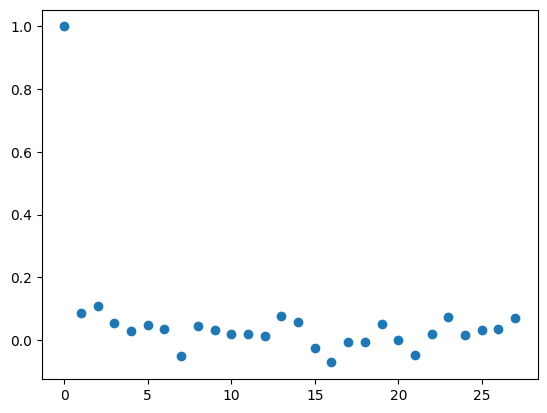

In [12]:
#calculate the autocorrelation function (for some randomly chosen parameters) just to 
#get a feeling for whether the trial results are correlated or not
acfREG = sm.tsa.acf(results.loc[(results["outcome"]==outcomes[1]) & 
            (results["sampleSize"]==sampleSizes[5]) &
            (results["duration"]==durations[0]),"reg"
            ])
plt.scatter(range(len(acfREG)),acfREG)
plt.show()

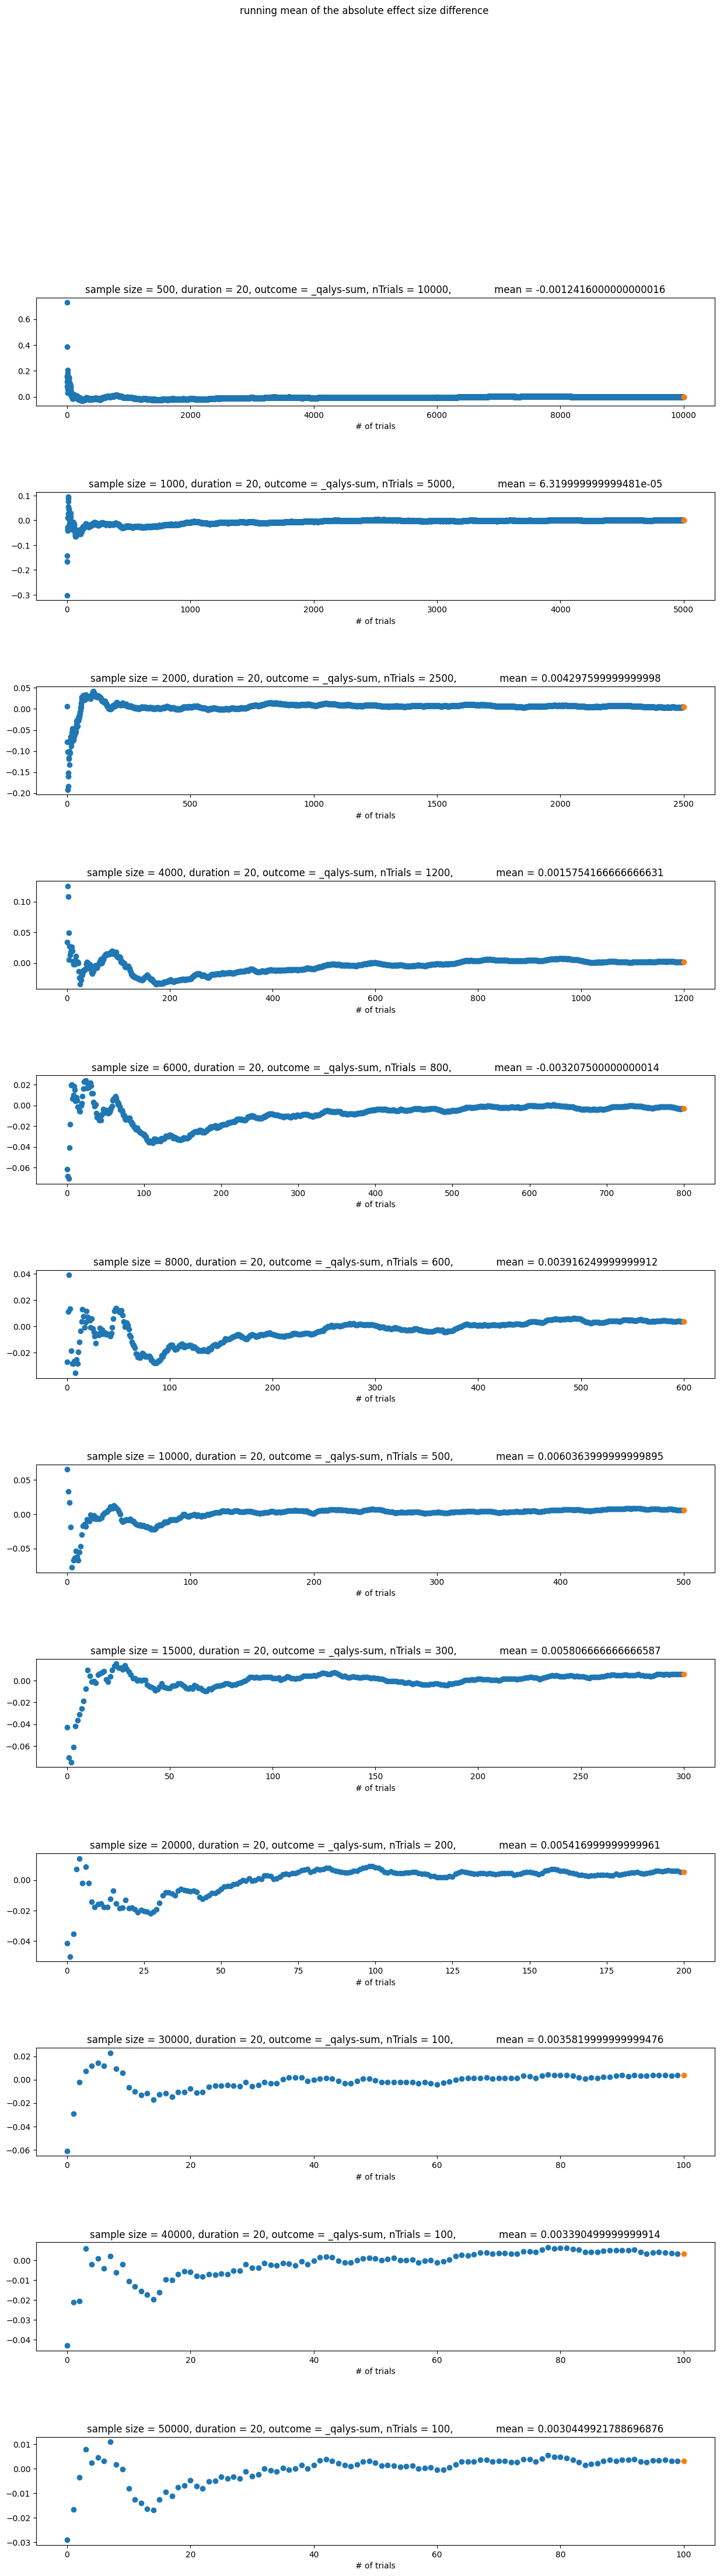

In [13]:
outcome = outcomes[4]
duration = durations[4]
#sampleSize = [sampleSizes[0]]
iCvRisk = 0
iDementiaRisk = 0

nPlots = len(sampleSizes)

plt.figure(figsize=(15,50))
plt.subplots_adjust(hspace=0.8)
plt.suptitle("running mean of the absolute effect size difference")

i = 1
for sampleSize in sampleSizes: 
                   
    plotData=results.loc[ #get all relevant data
                        (results["outcome"]==outcome) & 
                        (results["sampleSize"]==sampleSize) &
                        (results["OutcomeModelType.DEMENTIA"]==dementiaRisks[iDementiaRisk]) & 
                        (results["OutcomeModelType.CARDIOVASCULAR"]==cvRisks[iCvRisk]) &
                        (results["duration"]==duration), "runMeanAbsEffectSizeDiff"].copy()

    nTrials = plotData.shape[0]
    
    plt.subplot(nPlots,1,i) 
                    
    plt.title(f"""sample size = {sampleSize}, duration = {duration}, outcome = {outcome}, nTrials = {nTrials},\
              mean = {meanAbsEffectSizeDiff[f"{outcome},{duration},{sampleSize},{iCvRisk},{iDementiaRisk}"]}""")
    plt.xlabel("# of trials")
    #plt.ylabel("mean abs. effect size difference")
    plt.scatter(range(len(plotData)),plotData)
    plt.scatter(nTrials,meanAbsEffectSizeDiff[f"{outcome},{duration},{sampleSize},{iCvRisk},{iDementiaRisk}"])
    i = i+1
plt.show()

In [ ]:
#not useful to plot that many...
nPlots = len(outcomes) * len(durations) * len(sampleSizes) * len(dementiaRisks) * len(cvRisks)
nPlots = 1 * len(durations) * len(sampleSizes) * len(dementiaRisks) * len(cvRisks)

plt.figure(figsize=(15,12))
plt.suptitle("running mean of the absolute effect size difference")

i = 1
for outcome in [outcomes[0]]:
    for duration in durations: 
        for sampleSize in sampleSizes: 
            for iCvRisk in range(len(cvRisks)):
                for iDementiaRisk in range(len(dementiaRisks)):    
                    
                    plotData=results.loc[ #get all relevant data
                        (results["outcome"]==outcome) & 
                        (results["sampleSize"]==sampleSize) &
                        (results["OutcomeModelType.DEMENTIA"]==dementiaRisks[iDementiaRisk]) & 
                        (results["OutcomeModelType.CARDIOVASCULAR"]==cvRisks[iCvRisk]) &
                        (results["duration"]==duration), "runMeanAbsEffectSizeDiff"].copy()
                    
                    plt.subplot(int(nPlots/2),2,i) 
                    
                    plt.title(f"""sample size = {sampleSize}, duration = {duration}, outcome = {outcome}""")
                    plt.xlabel("# of trials")
                    #plt.ylabel("mean abs. effect size difference")
                    plt.scatter(range(len(plotData)),plotData)
                    #plt.scatter(nPoints,meanAbsEffectSizeDiff[f"""{outcome},
                    #                                              {duration},
                    #                                              {sampleSize},
                    #                                              {iCvRisk},
                    #                                              {iDementiaRisk}"""])
                    i = i+1
plt.show()
